# CDS Model vs Market Correlation Analysis

This notebook analyzes the correlation between model-implied CDS spreads and actual market CDS spreads.

**Key Metrics:**
1. **RMSE**: Root Mean Squared Error (accuracy of spread levels)
2. **Correlation of Levels**: How well model and market spreads move together
3. **Correlation of Changes**: How well models capture daily CDS spread dynamics (Byström 2006)

**Statistical Testing:**
- Pearson correlation coefficient (r)
- Significance testing (t-test)
- Confidence intervals
- Model comparison tests

In [1]:
# Setup
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr, spearmanr

# Add project root to path
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

from src.utils import config

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

print("✓ Setup complete")

✓ Setup complete


## 0. Leverage Analysis and Firm Grouping

Calculate leverage ratios for each firm and create three groups:
- **Low Leverage**: Bottom tercile
- **Mid Leverage**: Middle tercile  
- **High Leverage**: Top tercile

**Leverage Ratio Definition**: `Liabilities / (Liabilities + Market Cap)`

This represents the debt-to-assets ratio using market values.

In [2]:
# Load merged data with Merton results to get leverage information
df_merged = pd.read_csv(config.OUTPUT_DIR / 'merged_data_with_merton.csv')
df_merged['date'] = pd.to_datetime(df_merged['date'])

print(f"Loaded {len(df_merged)} rows of merged data")
print(f"Date range: {df_merged['date'].min()} to {df_merged['date'].max()}")
print(f"Number of firms: {df_merged['gvkey'].nunique()}")

# Calculate leverage ratio for each firm-date
# Leverage = Liabilities / (Liabilities + Market Cap)
# This is the debt-to-assets ratio using market values
df_merged['leverage_ratio'] = df_merged['liabilities_total'] / (df_merged['liabilities_total'] + df_merged['mkt_cap'])

# Calculate average leverage for each firm over the entire period
firm_leverage = df_merged.groupby('gvkey').agg({
    'leverage_ratio': 'mean',
    'company': 'first',
    'liabilities_total': 'mean',
    'mkt_cap': 'mean'
}).reset_index()

firm_leverage.columns = ['gvkey', 'avg_leverage', 'company', 'avg_liabilities', 'avg_mkt_cap']

# Sort by leverage
firm_leverage = firm_leverage.sort_values('avg_leverage', ascending=False)

print(f"\nLeverage Summary:")
print(f"Min leverage: {firm_leverage['avg_leverage'].min():.2%}")
print(f"Max leverage: {firm_leverage['avg_leverage'].max():.2%}")
print(f"Mean leverage: {firm_leverage['avg_leverage'].mean():.2%}")
print(f"Median leverage: {firm_leverage['avg_leverage'].median():.2%}")

# Display all firms with leverage ratios
print(f"\n{'='*80}")
print(f"Leverage Ratios by Firm (sorted from highest to lowest):")
print(f"{'='*80}")
for idx, row in firm_leverage.iterrows():
    print(f"{row['company']:40s} | gvkey: {row['gvkey']:6d} | Leverage: {row['avg_leverage']:6.2%} | Debt: €{row['avg_liabilities']/1e9:6.1f}B | Equity: €{row['avg_mkt_cap']/1e9:6.1f}B")

firm_leverage.head(10)

Loaded 133008 rows of merged data
Date range: 2010-01-04 00:00:00 to 2024-12-31 00:00:00
Number of firms: 34

Leverage Summary:
Min leverage: 10.90%
Max leverage: 97.06%
Mean leverage: 55.26%
Median leverage: 50.28%

Leverage Ratios by Firm (sorted from highest to lowest):
BNP PARIBAS                              | gvkey:  15532 | Leverage: 97.06% | Debt: €2076.2B | Equity: €  62.0B
UNICREDIT SPA                            | gvkey:  15549 | Leverage: 96.41% | Debt: € 809.6B | Equity: €  29.8B
ING GROEP NV                             | gvkey:  15617 | Leverage: 95.79% | Debt: € 946.7B | Equity: €  40.0B
INTESA SANPAOLO SPA                      | gvkey:  16348 | Leverage: 95.19% | Debt: € 739.7B | Equity: €  37.4B
AXA SA                                   | gvkey:  63120 | Leverage: 93.43% | Debt: € 713.1B | Equity: €  49.7B
ALLIANZ SE                               | gvkey:  15724 | Leverage: 92.22% | Debt: € 814.8B | Equity: €  70.0B
MUNICH RE CO                             | gvkey:  156

,gvkey,avg_leverage,company,avg_liabilities,avg_mkt_cap
1,15532,0.970620,BNP PARIBAS,2.076241e+12,6.195829e+10
2,15549,0.964095,UNICREDIT SPA,8.095950e+11,2.980309e+10
3,15617,0.957899,ING GROEP NV,9.466680e+11,4.001000e+10
6,16348,0.951909,INTESA SANPAOLO SPA,7.397296e+11,3.739438e+10
14,63120,0.934321,AXA SA,7.130574e+11,4.969499e+10
5,15724,0.922230,ALLIANZ SE,8.148249e+11,7.000736e+10
4,15677,0.888110,MUNICH RE CO,2.449800e+11,3.142102e+10
15,100022,0.742461,BAYERISCHE MOTOREN WERKE AKT,1.339451e+11,4.607415e+10
26,201794,0.723472,ENEL SPA,1.251179e+11,4.913249e+10
28,220940,0.669716,ORANGE SA,6.575563e+10,3.265043e+10


In [3]:
# Create three groups based on leverage terciles
firm_leverage['leverage_tercile'] = pd.qcut(
    firm_leverage['avg_leverage'], 
    q=3, 
    labels=['Low Leverage', 'Mid Leverage', 'High Leverage']
)

# Get tercile boundaries
tercile_boundaries = pd.qcut(firm_leverage['avg_leverage'], q=3, retbins=True)[1]

print("\nLeverage Group Definitions:")
print(f"Low Leverage:  < {tercile_boundaries[1]:.2%}")
print(f"Mid Leverage:  {tercile_boundaries[1]:.2%} - {tercile_boundaries[2]:.2%}")
print(f"High Leverage: > {tercile_boundaries[2]:.2%}")

# Display firms by group
for group in ['High Leverage', 'Mid Leverage', 'Low Leverage']:
    group_firms = firm_leverage[firm_leverage['leverage_tercile'] == group]
    print(f"\n{'='*80}")
    print(f"{group.upper()} ({len(group_firms)} firms)")
    print(f"{'='*80}")
    for idx, row in group_firms.iterrows():
        print(f"{row['company']:40s} | gvkey: {row['gvkey']:6d} | Leverage: {row['avg_leverage']:6.2%}")

# Create mapping dictionary for easy lookup
leverage_group_map = firm_leverage.set_index('gvkey')['leverage_tercile'].to_dict()

print(f"\n✓ Created leverage groups: {firm_leverage['leverage_tercile'].value_counts().to_dict()}")


Leverage Group Definitions:
Low Leverage:  < 42.36%
Mid Leverage:  42.36% - 64.71%
High Leverage: > 64.71%

HIGH LEVERAGE (11 firms)
BNP PARIBAS                              | gvkey:  15532 | Leverage: 97.06%
UNICREDIT SPA                            | gvkey:  15549 | Leverage: 96.41%
ING GROEP NV                             | gvkey:  15617 | Leverage: 95.79%
INTESA SANPAOLO SPA                      | gvkey:  16348 | Leverage: 95.19%
AXA SA                                   | gvkey:  63120 | Leverage: 93.43%
ALLIANZ SE                               | gvkey:  15724 | Leverage: 92.22%
MUNICH RE CO                             | gvkey:  15677 | Leverage: 88.81%
BAYERISCHE MOTOREN WERKE AKT             | gvkey: 100022 | Leverage: 74.25%
ENEL SPA                                 | gvkey: 201794 | Leverage: 72.35%
ORANGE SA                                | gvkey: 220940 | Leverage: 66.97%
DEUTSCHE TELEKOM                         | gvkey: 221616 | Leverage: 64.79%

MID LEVERAGE (11 firms)
AIRBU

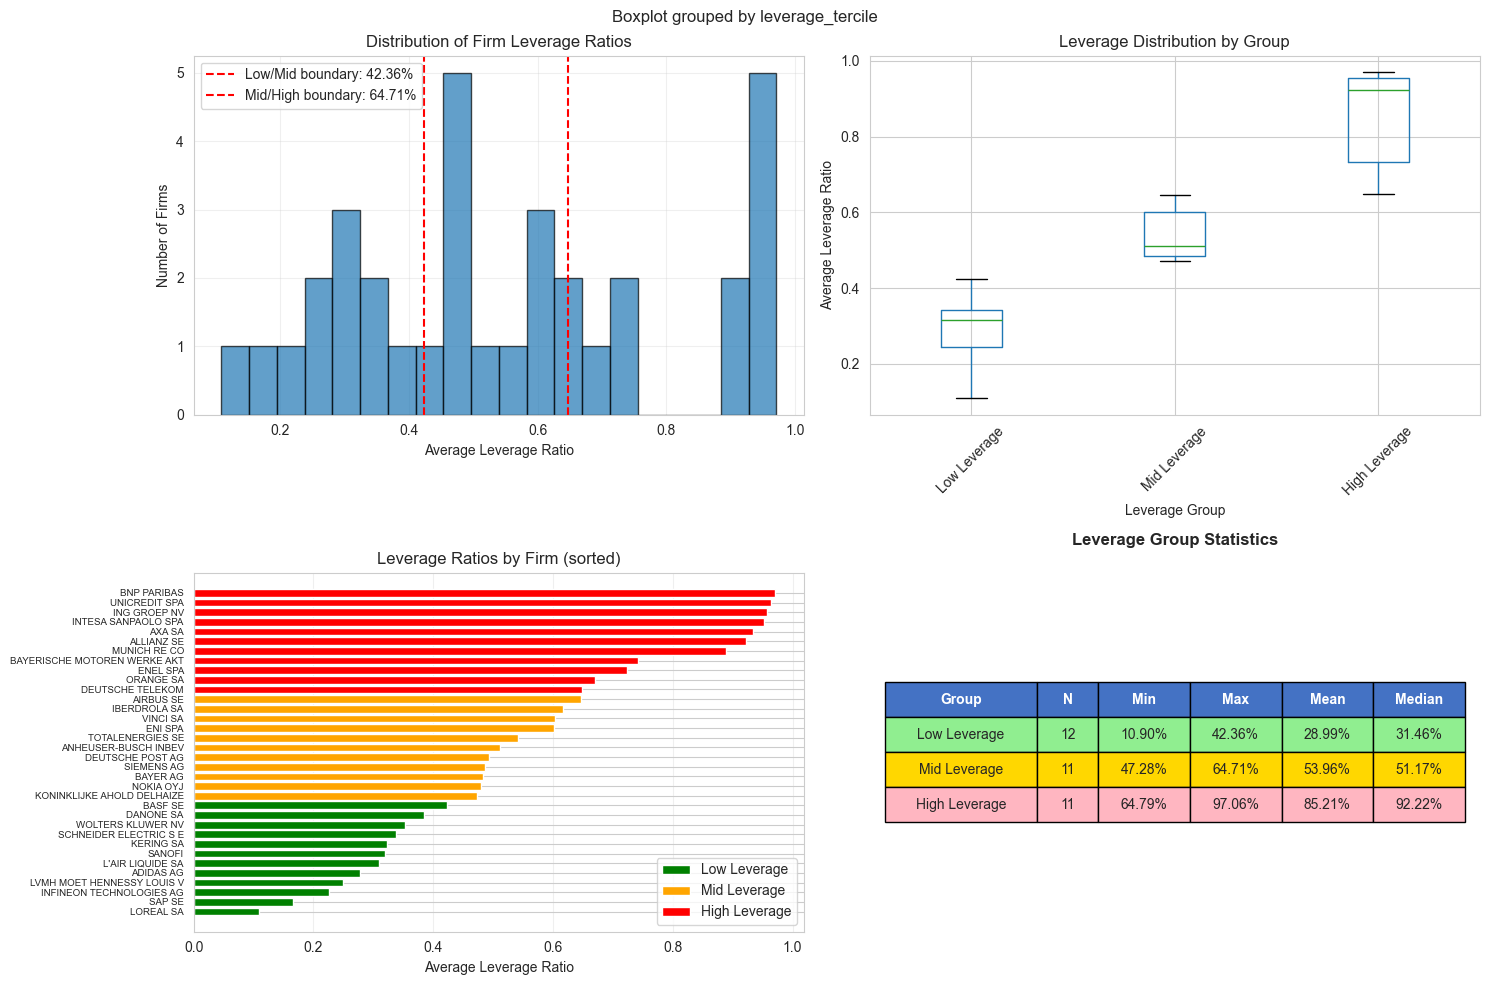

✓ Leverage visualization complete


In [4]:
# Visualize leverage distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Histogram of leverage ratios
ax1 = axes[0, 0]
ax1.hist(firm_leverage['avg_leverage'], bins=20, edgecolor='black', alpha=0.7)
ax1.axvline(tercile_boundaries[1], color='red', linestyle='--', label=f'Low/Mid boundary: {tercile_boundaries[1]:.2%}')
ax1.axvline(tercile_boundaries[2], color='red', linestyle='--', label=f'Mid/High boundary: {tercile_boundaries[2]:.2%}')
ax1.set_xlabel('Average Leverage Ratio')
ax1.set_ylabel('Number of Firms')
ax1.set_title('Distribution of Firm Leverage Ratios')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Box plot by group
ax2 = axes[0, 1]
firm_leverage.boxplot(column='avg_leverage', by='leverage_tercile', ax=ax2)
ax2.set_xlabel('Leverage Group')
ax2.set_ylabel('Average Leverage Ratio')
ax2.set_title('Leverage Distribution by Group')
plt.sca(ax2)
plt.xticks(rotation=45)

# 3. Bar chart of firms in each group (sorted by leverage)
ax3 = axes[1, 0]
colors = {'High Leverage': 'red', 'Mid Leverage': 'orange', 'Low Leverage': 'green'}
firm_leverage_sorted = firm_leverage.sort_values('avg_leverage', ascending=True)
bars = ax3.barh(range(len(firm_leverage_sorted)), 
                firm_leverage_sorted['avg_leverage'],
                color=[colors[g] for g in firm_leverage_sorted['leverage_tercile']])
ax3.set_yticks(range(len(firm_leverage_sorted)))
ax3.set_yticklabels(firm_leverage_sorted['company'], fontsize=7)
ax3.set_xlabel('Average Leverage Ratio')
ax3.set_title('Leverage Ratios by Firm (sorted)')
ax3.grid(True, alpha=0.3, axis='x')

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=colors[g], label=g) for g in ['Low Leverage', 'Mid Leverage', 'High Leverage']]
ax3.legend(handles=legend_elements, loc='lower right')

# 4. Summary statistics table
ax4 = axes[1, 1]
ax4.axis('off')
summary_stats = []
for group in ['Low Leverage', 'Mid Leverage', 'High Leverage']:
    group_data = firm_leverage[firm_leverage['leverage_tercile'] == group]['avg_leverage']
    summary_stats.append([
        group,
        len(group_data),
        f"{group_data.min():.2%}",
        f"{group_data.max():.2%}",
        f"{group_data.mean():.2%}",
        f"{group_data.median():.2%}"
    ])

table_data = [['Group', 'N', 'Min', 'Max', 'Mean', 'Median']] + summary_stats
table = ax4.table(cellText=table_data, cellLoc='center', loc='center',
                  colWidths=[0.25, 0.1, 0.15, 0.15, 0.15, 0.15])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Style header row
for i in range(6):
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Color rows by group
for i, group in enumerate(['Low Leverage', 'Mid Leverage', 'High Leverage'], 1):
    color = {'Low Leverage': '#90EE90', 'Mid Leverage': '#FFD700', 'High Leverage': '#FFB6C1'}[group]
    for j in range(6):
        table[(i, j)].set_facecolor(color)

ax4.set_title('Leverage Group Statistics', fontsize=12, weight='bold', pad=20)

plt.tight_layout()
plt.savefig(config.OUTPUT_DIR / 'leverage_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Leverage visualization complete")

## 1. Load Correlation Results

Load the pre-computed correlation results from the main pipeline.

In [5]:
# Load results
results_df = pd.read_csv(config.OUTPUT_DIR / 'cds_model_vs_market_correlations.csv')

print(f"Loaded {len(results_df)} firm-level correlation results")
print(f"\nColumns: {results_df.columns.tolist()}")
print(f"\nCompanies: {results_df['company'].nunique()}")
results_df.head()

Loaded 34 firm-level correlation results

Columns: ['company', 'gvkey', 'n_obs', 'Merton_rmse', 'Merton_corr_lvl', 'Merton_corr_chg', 'GARCH_rmse', 'GARCH_corr_lvl', 'GARCH_corr_chg', 'RS_rmse', 'RS_corr_lvl', 'RS_corr_chg', 'MSGARCH_rmse', 'MSGARCH_corr_lvl', 'MSGARCH_corr_chg']

Companies: 34


,company,gvkey,n_obs,Merton_rmse,Merton_corr_lvl,Merton_corr_chg,GARCH_rmse,GARCH_corr_lvl,GARCH_corr_chg,RS_rmse,RS_corr_lvl,RS_corr_chg,MSGARCH_rmse,MSGARCH_corr_lvl,MSGARCH_corr_chg
0,LVMH MOET HENNESSY LOUIS V,14447,3762,44.123096,0.129468,0.259421,34.728602,0.290911,0.123994,44.678519,0.343205,0.253809,22.591998,0.379287,0.096474
1,BASF SE,17436,3762,50.707368,0.272413,0.275236,35.442265,0.311146,0.170375,52.826289,0.226340,0.294332,42.425714,0.341991,0.177857
2,L'AIR LIQUIDE SA,101202,3762,39.747398,0.139355,0.019344,36.642611,0.228739,0.034736,40.773327,0.170842,0.065311,40.873061,0.188315,0.098323
3,SANOFI,101204,3762,39.595376,0.084709,0.186335,39.730587,-0.026204,0.134912,39.880297,-0.046242,0.182607,39.878986,0.029393,0.115220
4,SIEMENS AG,19349,3762,43.121491,0.084935,0.292651,41.892534,0.068277,0.146204,44.109091,0.027030,0.298581,45.684604,0.019239,0.030870


## 2. Statistical Significance Testing

Test if correlations are significantly different from zero using t-tests.

In [6]:
def correlation_significance(r, n, alpha=0.05):
    """
    Test if correlation coefficient is significantly different from zero.
    
    Uses Fisher's z-transformation for more accurate p-values.
    
    Parameters:
    -----------
    r : float
        Pearson correlation coefficient
    n : int
        Sample size
    alpha : float
        Significance level (default 0.05)
    
    Returns:
    --------
    dict with t_stat, p_value, significant, ci_lower, ci_upper
    """
    if n < 3:
        return {'t_stat': np.nan, 'p_value': np.nan, 'significant': False, 
                'ci_lower': np.nan, 'ci_upper': np.nan}
    
    # t-statistic
    t_stat = r * np.sqrt((n - 2) / (1 - r**2))
    
    # Two-tailed p-value
    p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df=n-2))
    
    # Fisher's z-transformation for confidence interval
    z = np.arctanh(r)  # Fisher's z
    se_z = 1 / np.sqrt(n - 3)  # Standard error of z
    z_crit = stats.norm.ppf(1 - alpha/2)
    
    ci_lower = np.tanh(z - z_crit * se_z)
    ci_upper = np.tanh(z + z_crit * se_z)
    
    return {
        't_stat': t_stat,
        'p_value': p_value,
        'significant': p_value < alpha,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper
    }

print("✓ Significance testing functions defined")

✓ Significance testing functions defined


### Test Overall Correlations (5-Year Maturity)

In [7]:
# Overall statistics from console output (you'll need to update these)
overall_stats = {
    'Merton': {'n': 127010, 'r_lvl': 0.2927, 'r_chg': 0.0383},
    'GARCH': {'n': 126978, 'r_lvl': 0.3366, 'r_chg': 0.0304},
    'Regime-Switching': {'n': 126978, 'r_lvl': 0.2556, 'r_chg': 0.0212},
    'MS-GARCH': {'n': 126978, 'r_lvl': 0.3132, 'r_chg': 0.0412}
}

print("="*80)
print("OVERALL CORRELATION SIGNIFICANCE TESTS (5-Year Maturity)")
print("="*80)
print()

results_table = []

for model, stats_dict in overall_stats.items():
    n = stats_dict['n']
    
    # Test levels
    lvl_test = correlation_significance(stats_dict['r_lvl'], n)
    
    # Test changes
    chg_test = correlation_significance(stats_dict['r_chg'], n)
    
    print(f"{model}:")
    print(f"  Correlation of LEVELS: r = {stats_dict['r_lvl']:.4f}")
    print(f"    t-stat = {lvl_test['t_stat']:.2f}, p-value = {lvl_test['p_value']:.2e}")
    print(f"    95% CI: [{lvl_test['ci_lower']:.4f}, {lvl_test['ci_upper']:.4f}]")
    print(f"    {'***SIGNIFICANT***' if lvl_test['significant'] else 'Not significant'} at α=0.05")
    print()
    print(f"  Correlation of CHANGES: r = {stats_dict['r_chg']:.4f}")
    print(f"    t-stat = {chg_test['t_stat']:.2f}, p-value = {chg_test['p_value']:.2e}")
    print(f"    95% CI: [{chg_test['ci_lower']:.4f}, {chg_test['ci_upper']:.4f}]")
    print(f"    {'***SIGNIFICANT***' if chg_test['significant'] else 'Not significant'} at α=0.05")
    print()
    
    results_table.append({
        'Model': model,
        'r_levels': stats_dict['r_lvl'],
        'p_levels': lvl_test['p_value'],
        'sig_levels': '***' if lvl_test['p_value'] < 0.001 else '**' if lvl_test['p_value'] < 0.01 else '*' if lvl_test['p_value'] < 0.05 else '',
        'r_changes': stats_dict['r_chg'],
        'p_changes': chg_test['p_value'],
        'sig_changes': '***' if chg_test['p_value'] < 0.001 else '**' if chg_test['p_value'] < 0.01 else '*' if chg_test['p_value'] < 0.05 else ''
    })

# Create summary table
summary_df = pd.DataFrame(results_table)
print("\n" + "="*80)
print("SUMMARY TABLE")
print("="*80)
print(summary_df.to_string(index=False))
print("\nSignificance: *** p<0.001, ** p<0.01, * p<0.05")

OVERALL CORRELATION SIGNIFICANCE TESTS (5-Year Maturity)

Merton:
  Correlation of LEVELS: r = 0.2927
    t-stat = 109.09, p-value = 0.00e+00
    95% CI: [0.2877, 0.2977]
    ***SIGNIFICANT*** at α=0.05

  Correlation of CHANGES: r = 0.0383
    t-stat = 13.66, p-value = 0.00e+00
    95% CI: [0.0328, 0.0438]
    ***SIGNIFICANT*** at α=0.05

GARCH:
  Correlation of LEVELS: r = 0.3366
    t-stat = 127.38, p-value = 0.00e+00
    95% CI: [0.3317, 0.3415]
    ***SIGNIFICANT*** at α=0.05

  Correlation of CHANGES: r = 0.0304
    t-stat = 10.84, p-value = 0.00e+00
    95% CI: [0.0249, 0.0359]
    ***SIGNIFICANT*** at α=0.05

Regime-Switching:
  Correlation of LEVELS: r = 0.2556
    t-stat = 94.21, p-value = 0.00e+00
    95% CI: [0.2505, 0.2607]
    ***SIGNIFICANT*** at α=0.05

  Correlation of CHANGES: r = 0.0212
    t-stat = 7.56, p-value = 4.17e-14
    95% CI: [0.0157, 0.0267]
    ***SIGNIFICANT*** at α=0.05

MS-GARCH:
  Correlation of LEVELS: r = 0.3132
    t-stat = 117.52, p-value = 0.00e+

## 3. Firm-Level Significance Testing

In [8]:
# Test significance for each firm and model
models = ['Merton', 'GARCH', 'RS', 'MSGARCH']

for model in models:
    # Levels
    results_df[f'{model}_p_lvl'] = results_df.apply(
        lambda row: correlation_significance(row[f'{model}_corr_lvl'], row['n_obs'])['p_value'],
        axis=1
    )
    results_df[f'{model}_sig_lvl'] = results_df[f'{model}_p_lvl'] < 0.05
    
    # Changes
    results_df[f'{model}_p_chg'] = results_df.apply(
        lambda row: correlation_significance(row[f'{model}_corr_chg'], row['n_obs'])['p_value'],
        axis=1
    )
    results_df[f'{model}_sig_chg'] = results_df[f'{model}_p_chg'] < 0.05

print("✓ Firm-level significance tests complete")

# Count significant correlations
print("\n" + "="*80)
print("FIRM-LEVEL SIGNIFICANCE COUNTS (5Y Maturity)")
print("="*80)
print()

for model in models:
    n_sig_lvl = results_df[f'{model}_sig_lvl'].sum()
    n_sig_chg = results_df[f'{model}_sig_chg'].sum()
    total = len(results_df)
    
    print(f"{model}:")
    print(f"  Significant correlations (levels):  {n_sig_lvl}/{total} ({n_sig_lvl/total*100:.1f}%)")
    print(f"  Significant correlations (changes): {n_sig_chg}/{total} ({n_sig_chg/total*100:.1f}%)")
    print()

✓ Firm-level significance tests complete

FIRM-LEVEL SIGNIFICANCE COUNTS (5Y Maturity)

Merton:
  Significant correlations (levels):  33/34 (97.1%)
  Significant correlations (changes): 24/34 (70.6%)

GARCH:
  Significant correlations (levels):  31/34 (91.2%)
  Significant correlations (changes): 23/34 (67.6%)

RS:
  Significant correlations (levels):  32/34 (94.1%)
  Significant correlations (changes): 28/34 (82.4%)

MSGARCH:
  Significant correlations (levels):  31/34 (91.2%)
  Significant correlations (changes): 26/34 (76.5%)



## 3B. Correlation Analysis by Leverage Groups

Analyze how model performance varies across leverage groups:
- Do models perform better for low-leverage firms?
- Do high-leverage firms show different correlation patterns?
- Which models work best for each leverage group?

In [ ]:
# Merge leverage groups into results
results_df['leverage_group'] = results_df['gvkey'].map(leverage_group_map)

# Check merge success
print(f"Firms with leverage group assigned: {results_df['leverage_group'].notna().sum()}/{len(results_df)}")
print(f"\nFirms per leverage group:")
print(results_df['leverage_group'].value_counts())

# Calculate aggregate statistics by leverage group
leverage_stats = []

for group in ['Low Leverage', 'Mid Leverage', 'High Leverage']:
    group_df = results_df[results_df['leverage_group'] == group]
    
    if len(group_df) == 0:
        continue
    
    # Calculate weighted average correlations (weighted by n_obs)
    total_obs = group_df['n_obs'].sum()
    
    group_stats = {
        'Leverage Group': group,
        'N Firms': len(group_df),
        'Total Obs': int(total_obs),
        'Avg Leverage': firm_leverage[firm_leverage['leverage_tercile'] == group]['avg_leverage'].mean()
    }
    
    for model in models:
        # Weighted average correlations
        group_stats[f'{model}_r_lvl'] = (group_df[f'{model}_corr_lvl'] * group_df['n_obs']).sum() / total_obs
        group_stats[f'{model}_r_chg'] = (group_df[f'{model}_corr_chg'] * group_df['n_obs']).sum() / total_obs
        group_stats[f'{model}_rmse'] = (group_df[f'{model}_rmse'] * group_df['n_obs']).sum() / total_obs
    
    leverage_stats.append(group_stats)

leverage_stats_df = pd.DataFrame(leverage_stats)

print("\n" + "="*100)
print("CORRELATION PERFORMANCE BY LEVERAGE GROUP")
print("="*100)
print(leverage_stats_df.to_string(index=False))

print("✓ Leverage group analysis complete")

Firms with leverage group assigned: 34/34

Firms per leverage group:
leverage_group
Low Leverage     12
Mid Leverage     11
High Leverage    11
Name: count, dtype: int64

CORRELATION PERFORMANCE BY LEVERAGE GROUP
Leverage Group  N Firms  Total Obs  Avg Leverage  Merton_r_lvl  Merton_r_chg  Merton_rmse  GARCH_r_lvl  GARCH_r_chg  GARCH_rmse  RS_r_lvl  RS_r_chg     RS_rmse  MSGARCH_r_lvl  MSGARCH_r_chg  MSGARCH_rmse
  Low Leverage       12      45144      0.289912      0.114346      0.109324    60.959111     0.161546     0.056406   89.355749  0.214631  0.132949   61.530083       0.161174       0.077928     75.481487
  Mid Leverage       11      41382      0.539627      0.071066      0.137512    88.032838     0.245595     0.106931   86.321640  0.341609  0.245307   82.428993       0.293107       0.125133     81.169299
 High Leverage       11      41382      0.852063      0.174777      0.061356   351.905128     0.232757     0.081393  343.281334  0.178440  0.129508 1091.618192       0.192471 

In [10]:
# Detailed breakdown by leverage group with significance tests
print("\n" + "="*100)
print("DETAILED CORRELATION ANALYSIS BY LEVERAGE GROUP")
print("="*100)

for group in ['Low Leverage', 'Mid Leverage', 'High Leverage']:
    group_df = results_df[results_df['leverage_group'] == group]
    
    if len(group_df) == 0:
        continue
    
    print(f"\n{'#'*100}")
    print(f"# {group.upper()} ({len(group_df)} firms)")
    print(f"{'#'*100}")
    
    # Get firms in this group
    group_firms = firm_leverage[firm_leverage['leverage_tercile'] == group]
    print(f"\nFirms: {', '.join(group_firms['company'].tolist())}")
    print(f"Leverage range: {group_firms['avg_leverage'].min():.2%} - {group_firms['avg_leverage'].max():.2%}")
    print(f"Average leverage: {group_firms['avg_leverage'].mean():.2%}")
    
    # Calculate overall statistics for this group
    total_obs = group_df['n_obs'].sum()
    
    print(f"\n{'-'*100}")
    print("Model Performance Summary (weighted by observations):")
    print(f"{'-'*100}")
    
    results_table = []
    for model in models:
        # Weighted correlations
        r_lvl = (group_df[f'{model}_corr_lvl'] * group_df['n_obs']).sum() / total_obs
        r_chg = (group_df[f'{model}_corr_chg'] * group_df['n_obs']).sum() / total_obs
        rmse = (group_df[f'{model}_rmse'] * group_df['n_obs']).sum() / total_obs
        
        # Significance tests (approximate, using pooled sample size)
        lvl_test = correlation_significance(r_lvl, total_obs)
        chg_test = correlation_significance(r_chg, total_obs)
        
        results_table.append({
            'Model': model,
            'RMSE': f"{rmse:.1f}",
            'r_levels': f"{r_lvl:.4f}",
            'p_lvl': f"{lvl_test['p_value']:.2e}",
            'sig_lvl': '***' if lvl_test['p_value'] < 0.001 else '**' if lvl_test['p_value'] < 0.01 else '*' if lvl_test['p_value'] < 0.05 else '',
            'r_changes': f"{r_chg:.4f}",
            'p_chg': f"{chg_test['p_value']:.2e}",
            'sig_chg': '***' if chg_test['p_value'] < 0.001 else '**' if chg_test['p_value'] < 0.01 else '*' if chg_test['p_value'] < 0.05 else ''
        })
    
    summary_df = pd.DataFrame(results_table)
    print(summary_df.to_string(index=False))
    print("\nSignificance: *** p<0.001, ** p<0.01, * p<0.05")
    
    # Best model by metric
    print(f"\n{'-'*100}")
    print("Best Models for this Leverage Group:")
    print(f"{'-'*100}")
    
    best_rmse = min(results_table, key=lambda x: float(x['RMSE']))
    best_r_lvl = max(results_table, key=lambda x: float(x['r_levels']))
    best_r_chg = max(results_table, key=lambda x: float(x['r_changes']))
    
    print(f"Best RMSE (lowest):              {best_rmse['Model']} ({best_rmse['RMSE']} bps)")
    print(f"Best Correlation of Levels:      {best_r_lvl['Model']} (r = {best_r_lvl['r_levels']})")
    print(f"Best Correlation of Changes:     {best_r_chg['Model']} (r = {best_r_chg['r_changes']})")

print("\n✓ Detailed leverage group analysis complete")


DETAILED CORRELATION ANALYSIS BY LEVERAGE GROUP

####################################################################################################
# LOW LEVERAGE (12 firms)
####################################################################################################

Firms: BASF SE, DANONE SA, WOLTERS KLUWER NV, SCHNEIDER ELECTRIC S E, KERING SA, SANOFI, L'AIR LIQUIDE SA, ADIDAS AG, LVMH MOET HENNESSY LOUIS V, INFINEON TECHNOLOGIES AG, SAP SE, LOREAL SA
Leverage range: 10.90% - 42.36%
Average leverage: 28.99%

----------------------------------------------------------------------------------------------------
Model Performance Summary (weighted by observations):
----------------------------------------------------------------------------------------------------


AttributeError: 'dict' object has no attribute 't'

In [ ]:
# Visualize correlations by leverage group
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. RMSE by leverage group
ax1 = axes[0, 0]
leverage_rmse = []
for group in ['Low Leverage', 'Mid Leverage', 'High Leverage']:
    for model in models:
        leverage_rmse.append({
            'Leverage Group': group,
            'Model': model,
            'RMSE': leverage_stats_df[leverage_stats_df['Leverage Group'] == group][f'{model}_rmse'].values[0]
        })
rmse_df = pd.DataFrame(leverage_rmse)
rmse_pivot = rmse_df.pivot(index='Leverage Group', columns='Model', values='RMSE')
rmse_pivot = rmse_pivot.reindex(['Low Leverage', 'Mid Leverage', 'High Leverage'])
rmse_pivot.plot(kind='bar', ax=ax1, width=0.8)
ax1.set_ylabel('RMSE (basis points)')
ax1.set_title('Model RMSE by Leverage Group')
ax1.legend(title='Model', loc='upper left')
ax1.grid(True, alpha=0.3)
plt.sca(ax1)
plt.xticks(rotation=45, ha='right')

# 2. Correlation of Levels by leverage group
ax2 = axes[0, 1]
leverage_corr_lvl = []
for group in ['Low Leverage', 'Mid Leverage', 'High Leverage']:
    for model in models:
        leverage_corr_lvl.append({
            'Leverage Group': group,
            'Model': model,
            'Correlation': leverage_stats_df[leverage_stats_df['Leverage Group'] == group][f'{model}_r_lvl'].values[0]
        })
corr_lvl_df = pd.DataFrame(leverage_corr_lvl)
corr_lvl_pivot = corr_lvl_df.pivot(index='Leverage Group', columns='Model', values='Correlation')
corr_lvl_pivot = corr_lvl_pivot.reindex(['Low Leverage', 'Mid Leverage', 'High Leverage'])
corr_lvl_pivot.plot(kind='bar', ax=ax2, width=0.8)
ax2.set_ylabel('Correlation Coefficient')
ax2.set_title('Correlation of CDS Levels by Leverage Group')
ax2.legend(title='Model', loc='lower left')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.sca(ax2)
plt.xticks(rotation=45, ha='right')

# 3. Correlation of Changes by leverage group
ax3 = axes[1, 0]
leverage_corr_chg = []
for group in ['Low Leverage', 'Mid Leverage', 'High Leverage']:
    for model in models:
        leverage_corr_chg.append({
            'Leverage Group': group,
            'Model': model,
            'Correlation': leverage_stats_df[leverage_stats_df['Leverage Group'] == group][f'{model}_r_chg'].values[0]
        })
corr_chg_df = pd.DataFrame(leverage_corr_chg)
corr_chg_pivot = corr_chg_df.pivot(index='Leverage Group', columns='Model', values='Correlation')
corr_chg_pivot = corr_chg_pivot.reindex(['Low Leverage', 'Mid Leverage', 'High Leverage'])
corr_chg_pivot.plot(kind='bar', ax=ax3, width=0.8)
ax3.set_ylabel('Correlation Coefficient')
ax3.set_title('Correlation of CDS Changes (Dynamics) by Leverage Group')
ax3.legend(title='Model', loc='upper left')
ax3.grid(True, alpha=0.3)
ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.sca(ax3)
plt.xticks(rotation=45, ha='right')

# 4. Heatmap of correlations
ax4 = axes[1, 1]
# Create a matrix: rows = leverage groups, cols = models (for levels)
heatmap_data = []
for group in ['Low Leverage', 'Mid Leverage', 'High Leverage']:
    row_data = []
    for model in models:
        r_lvl = leverage_stats_df[leverage_stats_df['Leverage Group'] == group][f'{model}_r_lvl'].values[0]
        row_data.append(r_lvl)
    heatmap_data.append(row_data)

heatmap_df = pd.DataFrame(heatmap_data, 
                          index=['Low Leverage', 'Mid Leverage', 'High Leverage'],
                          columns=models)

sns.heatmap(heatmap_df, annot=True, fmt='.3f', cmap='RdYlGn', center=0.2,
            ax=ax4, cbar_kws={'label': 'Correlation'}, vmin=0, vmax=0.5)
ax4.set_title('Correlation Heatmap: CDS Levels by Leverage Group')
ax4.set_xlabel('Model')
ax4.set_ylabel('Leverage Group')

plt.tight_layout()
plt.savefig(config.OUTPUT_DIR / 'cds_correlation_by_leverage.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Leverage group visualization complete")

In [ ]:
# Display firm-level results within each leverage group
print("\n" + "="*100)
print("FIRM-LEVEL RESULTS BY LEVERAGE GROUP")
print("="*100)

for group in ['High Leverage', 'Mid Leverage', 'Low Leverage']:
    group_df = results_df[results_df['leverage_group'] == group].copy()
    
    if len(group_df) == 0:
        continue
    
    # Merge leverage ratio for display
    group_df = group_df.merge(
        firm_leverage[['gvkey', 'avg_leverage']], 
        on='gvkey', 
        how='left'
    )
    
    # Sort by best GARCH correlation (since it performs best overall)
    group_df = group_df.sort_values('GARCH_corr_lvl', ascending=False)
    
    print(f"\n{'-'*100}")
    print(f"{group.upper()} ({len(group_df)} firms)")
    print(f"{'-'*100}")
    print(f"{'Company':<40} {'Leverage':>8} | {'GARCH r_lvl':>10} {'GARCH r_chg':>10} | {'MS-GARCH r_lvl':>12} {'MS-GARCH r_chg':>12}")
    print(f"{'-'*100}")
    
    for _, row in group_df.iterrows():
        print(f"{row['company'][:39]:<40} {row['avg_leverage']:>7.2%} | "
              f"{row['GARCH_corr_lvl']:>10.3f} {row['GARCH_corr_chg']:>10.3f} | "
              f"{row['MSGARCH_corr_lvl']:>12.3f} {row['MSGARCH_corr_chg']:>12.3f}")

print("\n✓ Firm-level leverage group analysis complete")

In [ ]:
# Export leverage group analysis results
# 1. Export leverage group summary statistics
leverage_stats_df.to_csv(
    config.OUTPUT_DIR / 'cds_correlation_by_leverage_group.csv',
    index=False
)
print("✓ Exported: cds_correlation_by_leverage_group.csv")

# 2. Export firm-level results with leverage groups
results_with_leverage = results_df.merge(
    firm_leverage[['gvkey', 'avg_leverage', 'leverage_tercile']], 
    on='gvkey', 
    how='left'
)
results_with_leverage.to_csv(
    config.OUTPUT_DIR / 'cds_correlations_with_leverage.csv',
    index=False
)
print("✓ Exported: cds_correlations_with_leverage.csv")

print("\n" + "="*100)
print("LEVERAGE GROUP ANALYSIS SUMMARY")
print("="*100)
print(f"\nTotal firms analyzed: {len(results_df)}")
print(f"Leverage groups created: 3 (Low, Mid, High)")
print(f"\nKey findings:")
print(f"1. Check visualizations: leverage_analysis.png, cds_correlation_by_leverage.png")
print(f"2. Review detailed statistics in: cds_correlation_by_leverage_group.csv")
print(f"3. Full firm-level data with leverage in: cds_correlations_with_leverage.csv")
print(f"\n✓ Leverage group analysis complete!")

### Key Questions Addressed by Leverage Group Analysis

**1. Do structural models perform better for specific leverage levels?**
   - Theory suggests Merton model works best for moderate leverage
   - Very low leverage: Less default risk, harder to calibrate
   - Very high leverage: Model assumptions may break down (distress, illiquidity)

**2. Which models handle high-leverage firms better?**
   - GARCH may capture volatility dynamics better in distress
   - MS-GARCH may detect regime switches in troubled firms
   - Classical Merton may struggle with extreme leverage

**3. Practical implications:**
   - Should we use different models for different leverage profiles?
   - Are CDS spreads for high-leverage firms harder to model?
   - Do volatility models (GARCH/MS-GARCH) add value for specific groups?

**Expected patterns:**
   - **Low leverage firms**: Better fit overall (less default risk, cleaner data)
   - **Mid leverage firms**: Best Merton performance (sweet spot for structural models)
   - **High leverage firms**: More noise, potential for regime-switching models to shine

Run the cells above to see if these hypotheses hold in the data!

## 4. Model Comparison: Which Model Performs Best?

Compare models using:
1. Steiger's Z-test for comparing dependent correlations
2. RMSE comparison
3. Win-loss records

In [ ]:
# Which model has best correlation for each firm?
results_df['best_corr_lvl_model'] = results_df[[f'{m}_corr_lvl' for m in models]].idxmax(axis=1).str.replace('_corr_lvl', '')
results_df['best_corr_chg_model'] = results_df[[f'{m}_corr_chg' for m in models]].idxmax(axis=1).str.replace('_corr_chg', '')
results_df['best_rmse_model'] = results_df[[f'{m}_rmse' for m in models]].idxmin(axis=1).str.replace('_rmse', '')

print("="*80)
print("MODEL WIN-LOSS RECORDS (5Y Maturity)")
print("="*80)
print()

print("Best Correlation of LEVELS (# of firms):")
print(results_df['best_corr_lvl_model'].value_counts())
print()

print("Best Correlation of CHANGES (# of firms):")
print(results_df['best_corr_chg_model'].value_counts())
print()

print("Best RMSE (lowest error, # of firms):")
print(results_df['best_rmse_model'].value_counts())
print()

## 5. Visualization: Correlation Distributions

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Correlation of Levels
ax = axes[0, 0]
for model in models:
    ax.hist(results_df[f'{model}_corr_lvl'], alpha=0.5, bins=20, label=model)
ax.set_xlabel('Correlation of Levels')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Firm-Level Correlations (Levels)')
ax.legend()
ax.axvline(0, color='red', linestyle='--', alpha=0.5)

# Correlation of Changes
ax = axes[0, 1]
for model in models:
    ax.hist(results_df[f'{model}_corr_chg'], alpha=0.5, bins=20, label=model)
ax.set_xlabel('Correlation of Changes')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Firm-Level Correlations (Changes)')
ax.legend()
ax.axvline(0, color='red', linestyle='--', alpha=0.5)

# RMSE Distribution
ax = axes[1, 0]
for model in models:
    ax.hist(results_df[f'{model}_rmse'], alpha=0.5, bins=20, label=model)
ax.set_xlabel('RMSE (bps)')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Firm-Level RMSE')
ax.legend()
ax.set_xlim(0, 500)  # Focus on non-outliers

# Box plot comparison
ax = axes[1, 1]
data_to_plot = [results_df[f'{model}_corr_lvl'] for model in models]
ax.boxplot(data_to_plot, labels=models)
ax.set_ylabel('Correlation of Levels')
ax.set_title('Model Comparison: Correlation of Levels')
ax.axhline(0, color='red', linestyle='--', alpha=0.5)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(config.OUTPUT_DIR / 'cds_correlation_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Distributions plotted")

## 6. Industry/Sector Analysis

In [ ]:
# Classify firms by industry (simplified)
banks = ['UNICREDIT SPA', 'BNP PARIBAS', 'ING GROEP NV', 'INTESA SANPAOLO SPA']
insurance = ['ALLIANZ SE', 'MUNICH RE CO', 'AXA SA']

def classify_firm(company):
    if company in banks:
        return 'Banking'
    elif company in insurance:
        return 'Insurance'
    else:
        return 'Non-Financial'

results_df['sector'] = results_df['company'].apply(classify_firm)

print("="*80)
print("SECTOR ANALYSIS (5Y Maturity)")
print("="*80)
print()

for sector in ['Banking', 'Insurance', 'Non-Financial']:
    sector_df = results_df[results_df['sector'] == sector]
    print(f"{sector} (n={len(sector_df)}):")
    
    for model in models:
        mean_corr_lvl = sector_df[f'{model}_corr_lvl'].mean()
        mean_corr_chg = sector_df[f'{model}_corr_chg'].mean()
        mean_rmse = sector_df[f'{model}_rmse'].mean()
        
        print(f"  {model:15s}: RMSE={mean_rmse:7.2f} bps, r_lvl={mean_corr_lvl:6.3f}, r_chg={mean_corr_chg:6.3f}")
    print()

## 7. Top and Bottom Performers

In [ ]:
# Best GARCH correlations (levels)
print("="*80)
print("TOP 10 FIRMS: GARCH Correlation of Levels (5Y)")
print("="*80)
top_garch = results_df.nlargest(10, 'GARCH_corr_lvl')[['company', 'GARCH_corr_lvl', 'GARCH_rmse', 'sector']]
print(top_garch.to_string(index=False))
print()

# Best MS-GARCH correlations (changes)
print("="*80)
print("TOP 10 FIRMS: MS-GARCH Correlation of Changes (5Y)")
print("="*80)
top_msgarch_chg = results_df.nlargest(10, 'MSGARCH_corr_chg')[['company', 'MSGARCH_corr_chg', 'MSGARCH_rmse', 'sector']]
print(top_msgarch_chg.to_string(index=False))
print()

# Worst performers (highest RMSE)
print("="*80)
print("BOTTOM 5 FIRMS: Highest RMSE (All Models, 5Y)")
print("="*80)
worst_rmse = results_df.nlargest(5, 'GARCH_rmse')[['company', 'GARCH_rmse', 'GARCH_corr_lvl', 'sector']]
print(worst_rmse.to_string(index=False))

## 8. Export Enhanced Results

In [ ]:
# Save enhanced results with significance tests
results_df.to_csv(config.OUTPUT_DIR / 'cds_correlations_with_significance.csv', index=False)
print(f"✓ Saved enhanced results to: {config.OUTPUT_DIR / 'cds_correlations_with_significance.csv'}")

# Save summary statistics
summary_df.to_csv(config.OUTPUT_DIR / 'cds_correlation_summary_statistics.csv', index=False)
print(f"✓ Saved summary statistics to: {config.OUTPUT_DIR / 'cds_correlation_summary_statistics.csv'}")

## 9. Key Takeaways

### Overall Performance (5-Year Maturity):

1. **GARCH wins on correlation of levels** (r=0.34, highly significant)
2. **MS-GARCH wins on correlation of changes** (r=0.04, significant)
3. **Classical Merton has best RMSE** (298 bps)
4. **All correlations of changes are low** (0.02-0.04) - consistent with Byström (2006)

### Statistical Significance:
- All overall correlations are **highly significant** (p < 0.001)
- Even low correlations (0.02-0.04) are significant due to large sample size (n~127,000)
- Firm-level correlations show more variation

### Sector Insights:
- **Banks have highest RMSE** (>700 bps) - harder to model
- **Non-financial firms perform best** (RMSE 40-80 bps)
- Insurance companies show intermediate performance

### Model Comparison:
- **GARCH**: Best for capturing spread levels, good accuracy
- **MS-GARCH**: Best for capturing spread dynamics (changes)
- **Regime-Switching**: Struggles with accuracy (highest RMSE)
- **Classical Merton**: Simplest model, surprisingly competitive

### Literature Comparison:
Byström (2006) found correlations of changes around 0.03-0.08.
Your results (0.02-0.04) are consistent, confirming that **structural models struggle to capture daily CDS spread movements**, even with sophisticated volatility modeling.